# Intro 

This book uses the IB InSync library:  https://github.com/erdewit/ib_insync 

In [1]:
from ib_insync import *
import math
import pandas as pd
import math
from datetime import datetime, date, timedelta
import time
from collections import deque
from contracts_defs import *

util.startLoop()

ib = IB()

ib.connect('127.0.0.1', 4001, clientId=1236)

<IB connected to 127.0.0.1:4001 clientId=1236>

In [2]:
underlying = Dax().underlying
contracts = ib.qualifyContracts(underlying)
print(f'Identified {contracts}')
underlying = contracts[0] # using first contract

ib.reqMarketDataType(4)

price_sources = ib.qualifyContracts(Dax().price_source)
print(f'Fetched {price_sources} price sources.')
price_source = price_sources[0]


[ticker] = ib.reqTickers(price_source)
ref_price = ticker.marketPrice()
ul_value = ref_price
print(f'Ref price {ref_price} ... ')


Identified [Index(conId=825711, symbol='DAX', exchange='DTB', currency='EUR', localSymbol='DAX')]
Fetched [Contract(secType='FUT', conId=478022838, symbol='DAX', lastTradeDateOrContractMonth='20211217', multiplier='25', exchange='DTB', currency='EUR', localSymbol='FDAX DEC 21', tradingClass='FDAX')] price sources.
Ref price 15653.5 ... 


... Pulling option chains. 

In [3]:

# request option chains ...
chains = ib.reqSecDefOptParams(underlying.symbol, '', underlying.secType, underlying.conId)
# formatting for data frame .. 
df_chains = util.df(chains)
df_chains
#print('original:')
#print(chains)

,exchange,underlyingConId,tradingClass,multiplier,expirations,strikes
0,DTB,825711,ODAX,5,"[20211217, 20220121, 20220218, 20220318, 20220...","[1000.0, 2000.0, 2500.0, 3000.0, 3500.0, 4000...."
1,DTB,825711,ODX4,5,[20211223],"[13850.0, 13900.0, 13950.0, 14000.0, 14050.0, ..."
2,DTB,825711,ODX1,5,[20220107],"[13900.0, 13950.0, 14000.0, 14050.0, 14100.0, ..."
3,DTB,825711,ODX2,5,[20211210],"[13850.0, 13900.0, 13950.0, 14000.0, 14050.0, ..."
4,DTB,825711,ODX5,5,[20211230],"[13850.0, 13900.0, 13950.0, 14000.0, 14050.0, ..."


In [4]:
# chains must be an IB chains object. 
# this will not return chains that expiry on the same day, even if min_days_to_expiry is 0 (unless called at 00:00:00)
def get_next_chain(chains, ref_date, min_days_to_expiry):
    #
    minimal_date = ref_date + timedelta(days=min_days_to_expiry)
    print(f'Minimal expiry date: {minimal_date}')
    chain_candidate = None
    found_min_date = None
    for chain in chains:
        #print(chain)
        for expiry in chain.expirations:
            #print(expiry)
            exp_date = datetime.strptime(expiry, "%Y%m%d")
            if exp_date > minimal_date:
                if found_min_date == None:
                    found_min_date = exp_date
                    chain_candidate = chain
                # need to check if this is sooner than before 
                if exp_date < found_min_date:
                    found_min_date = exp_date
                    chain_candidate = chain
    return(chain_candidate)
                

base = datetime.today()
opt_chain = get_next_chain(chains, base, 2)
print(f'Relevant chain {opt_chain}')


Minimal expiry date: 2021-12-11 16:22:00.639505
Relevant chain OptionChain(exchange='DTB', underlyingConId='825711', tradingClass='ODAX', multiplier='5', expirations=['20211217', '20220121', '20220218', '20220318', '20220617', '20220916', '20221216', '20230616', '20231215', '20240621', '20241220', '20251219'], strikes=[1000.0, 2000.0, 2500.0, 3000.0, 3500.0, 4000.0, 4500.0, 5000.0, 5500.0, 6000.0, 6500.0, 6800.0, 7000.0, 7200.0, 7400.0, 7500.0, 7600.0, 7800.0, 8000.0, 8200.0, 8400.0, 8500.0, 8600.0, 8800.0, 8900.0, 9000.0, 9100.0, 9200.0, 9300.0, 9400.0, 9500.0, 9600.0, 9700.0, 9800.0, 9900.0, 10000.0, 10100.0, 10200.0, 10300.0, 10400.0, 10500.0, 10600.0, 10700.0, 10800.0, 10900.0, 11000.0, 11100.0, 11200.0, 11300.0, 11400.0, 11500.0, 11600.0, 11650.0, 11700.0, 11750.0, 11800.0, 11850.0, 11900.0, 11950.0, 12000.0, 12050.0, 12100.0, 12200.0, 12300.0, 12350.0, 12400.0, 12500.0, 12600.0, 12700.0, 12800.0, 12900.0, 13000.0, 13100.0, 13200.0, 13250.0, 13300.0, 13350.0, 13400.0, 13450.0, 135

In [5]:

# let's assemble the relevant strikes. 
num_of_strikes_above_and_below_ref_price = 3
lower_strikes = deque([], maxlen=num_of_strikes_above_and_below_ref_price)
upper_strikes = [] # deque([], maxlen=num_of_strikes_above_and_below_ref_price)

# strikes is an ordered list where lowest strikes come first
for strike in opt_chain.strikes:
    # 
    if strike<ul_value:
        lower_strikes.append(strike)
    if strike>ul_value:
        upper_strikes.append(strike)
        if len(upper_strikes)==num_of_strikes_above_and_below_ref_price:
            break
    
print(f'Ref price: {ul_value} lower strikes: {lower_strikes} and upper strikes: {upper_strikes}')


Ref price: 15653.5 lower strikes: deque([15550.0, 15600.0, 15650.0], maxlen=3) and upper strikes: [15700.0, 15750.0, 15800.0]


In [6]:
rights = ['C','P']

lower_contracts = [Option(symbol=underlying.symbol, lastTradeDateOrContractMonth=opt_chain.expirations[0], strike=strike, right=right, exchange=opt_chain.exchange, tradingClass=opt_chain.tradingClass, multiplier=opt_chain.multiplier)
        for right in rights
        for strike in lower_strikes]
lower_contracts = ib.qualifyContracts(*lower_contracts)

upper_contracts = [Option(symbol=underlying.symbol, lastTradeDateOrContractMonth=opt_chain.expirations[0], strike=strike, right=right, exchange=opt_chain.exchange, tradingClass=opt_chain.tradingClass, multiplier=opt_chain.multiplier)
        for right in rights
        for strike in upper_strikes]
upper_contracts = ib.qualifyContracts(*upper_contracts)

print(f'Qualified {len(lower_contracts)} valid lower contracts')
print(f'Qualified {len(upper_contracts)} valid upper contracts')


Qualified 6 valid lower contracts
Qualified 6 valid upper contracts


In [7]:
if False:
    strikes = [strike for strike in chain.strikes]
    expirations = sorted(exp for exp in chain.expirations)[:1]
    rights = ['P', 'C']

    print('Assembling unqualified contracts ...')
    unqualified_contracts = [Option(symbol=underlying.symbol, lastTradeDateOrContractMonth=expiration, strike=strike, right=right, exchange=chain.exchange, tradingClass=chain.tradingClass)
            for right in rights
            for expiration in expirations
            for strike in strikes]


    print(f'... {len(unqualified_contracts)}')

    def chunks(lst, n):
        """Yield successive n-sized chunks from lst."""
        for i in range(0, len(lst), n):
            yield lst[i:i + n]


    contract_chunks = chunks(unqualified_contracts, 100)
    #print(list(contract_chunks))

    contracts = []

    for chunk in contract_chunks: 
        print('Processing chunk ...')
        qualified_contracts = ib.qualifyContracts(*chunk)
        for c in qualified_contracts:
            contracts.append(c)
        print('10 seconds sleep ...')
        time.sleep(10)

    print(f'Fecthed {len(contracts)} contracts ...')

In [8]:
if False:
    contract_chunks = chunks(contracts, 30)
    #print(list(contract_chunks))

    tickers = []

    for chunk in contract_chunks: 
        print('Processing chunk ...')
        for c in chunk: 
            t = ib.reqMktData(c, snapshot = True)
            tickers.append(t)
        #ticker_res = ib.reqTickers(*chunk)
        #for c in ticker_res:
        #    tickers.append(c)
        print('0.5 seconds sleep ...')
        time.sleep(0.5)

    

In [21]:

tickers = []
contracts = []
contracts += lower_contracts
contracts += upper_contracts

for c in contracts:
    print(ib.pendingTickersEvent)
    t = ib.reqMktData(c, snapshot = True)
    tickers.append(t)
    print('0.1 seconds sleep ...')
    #time.sleep(0.1)

    
print(ib.pendingTickersEvent)
#for tickers in ib.pendingTickersEvent:
#    for ticker in tickers:
#        print(ticker)
time.sleep(10)
print(ib.pendingTickersEvent)
print(len(tickers))
for t in tickers: 
    print(t)

Event<pendingTickersEvent, []>
0.1 seconds sleep ...
Event<pendingTickersEvent, []>
0.1 seconds sleep ...
Event<pendingTickersEvent, []>
0.1 seconds sleep ...
Event<pendingTickersEvent, []>
0.1 seconds sleep ...
Event<pendingTickersEvent, []>
0.1 seconds sleep ...
Event<pendingTickersEvent, []>
0.1 seconds sleep ...
Event<pendingTickersEvent, []>
0.1 seconds sleep ...
Event<pendingTickersEvent, []>
0.1 seconds sleep ...
Event<pendingTickersEvent, []>
0.1 seconds sleep ...
Event<pendingTickersEvent, []>
0.1 seconds sleep ...
Event<pendingTickersEvent, []>
0.1 seconds sleep ...
Event<pendingTickersEvent, []>
0.1 seconds sleep ...
Event<pendingTickersEvent, []>
Event<pendingTickersEvent, []>
12
Ticker(contract=Option(conId=515886571, symbol='DAX', lastTradeDateOrContractMonth='20211217', strike=15550.0, right='C', multiplier='5', exchange='DTB', currency='EUR', localSymbol='C ODAX DEC 21 1555000', tradingClass='ODAX'), time=datetime.datetime(2021, 12, 9, 15, 22, 13, 471573, tzinfo=datetim

In [22]:
import QuantLib as ql

import pandas as pd
imp_vol_df = pd.DataFrame(columns=['strike', 'expiration', 'right', 'imp_vol_ql', 'imp_vol_ib', 'mid_point', 'delta','gamma', 'vega','theta'])
for t in tickers:   
    try:
        mp = (t.bid+t.ask)/2
        mq = (t.bidSize + t.askSize)/2
        print(mp)
        if mp>0:
            exercise = ql.EuropeanExercise(ql.DateParser.parseFormatted(t.contract.lastTradeDateOrContractMonth, '%Y%m%d'))
            
            # ok, i have a full quote ... 
            K = t.contract.strike
            T = ql.Actual360().yearFraction(ql.DateParser.parseFormatted('20211203', '%Y%m%d'), ql.DateParser.parseFormatted(t.contract.lastTradeDateOrContractMonth, '%Y%m%d'))
            N = max(200, int(1000 * T))
            M = max(100, int(200 *T))
        
            imp_vol = 0
            
            if t.contract.right == 'P':                
                payoff = ql.PlainVanillaPayoff(ql.Option.Put, K)
                option = ql.EuropeanOption(payoff,exercise)
            
            if t.contract.right == 'C':
                payoff = ql.PlainVanillaPayoff(ql.Option.Call, K)
                option = ql.EuropeanOption(payoff,exercise)
                
            S = ql.QuoteHandle(ql.SimpleQuote(ul_value))
            r = ql.YieldTermStructureHandle(ql.FlatForward(0, ql.TARGET(), 0.03, ql.Actual360()))
            q = ql.YieldTermStructureHandle(ql.FlatForward(0, ql.TARGET(), 0.01, ql.Actual360()))
            sigma = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(0, ql.TARGET(), 0.20, ql.Actual360()))
            process = ql.BlackScholesMertonProcess(S,q,r,sigma)
            engine = ql.FdBlackScholesVanillaEngine(process, M, N, 0, ql.FdmSchemeDesc.ImplicitEuler())

            imp_vol = option.impliedVolatility(mp, process)
            option.setPricingEngine(engine)    

            imp_vol_ib = 0
            delta = option.delta()
            

            imp_vol_df = imp_vol_df.append({'strike':t.contract.strike, 'expiration':t.contract.lastTradeDateOrContractMonth, 'right':t.contract.right, 
                                            'imp_vol_ql':imp_vol, 'imp_vol_ib':0,'mid_point':mp,
                                            'delta':option.delta(),'gamma':option.gamma(),'theta':option.theta()
                                           }, ignore_index=True)
        
    except Exception as inst:
        print(type(inst))    # the exception instance
        print(inst.args)     # arguments stored in .args
        print(inst)     
        print(t)


222.25
189.5
158.75
134.5
151.5
171.0
131.25
106.25
85.25
193.25
218.75
247.5


In [23]:
imp_vol_df = imp_vol_df.sort_values(['strike', 'right'])
imp_vol_df

,strike,expiration,right,imp_vol_ql,imp_vol_ib,mid_point,delta,gamma,vega,theta
0,15550.0,20211217,C,0.173681,0,222.25,0.599861,0.000831,NaN,-4368.429827
3,15550.0,20211217,P,0.198901,0,134.50,-0.400053,0.000831,NaN,-4058.626427
1,15600.0,20211217,C,0.169487,0,189.50,0.557615,0.000849,NaN,-4452.243568
4,15600.0,20211217,P,0.193879,0,151.50,-0.442298,0.000849,NaN,-4140.941266
2,15650.0,20211217,C,0.164951,0,158.75,0.514837,0.000857,NaN,-4483.512454
5,15650.0,20211217,P,0.189360,0,171.00,-0.485076,0.000857,NaN,-4170.711279
6,15700.0,20211217,C,0.161159,0,131.25,0.472024,0.000856,NaN,-4461.261139
9,15700.0,20211217,P,0.185406,0,193.25,-0.527889,0.000856,NaN,-4146.961120
7,15750.0,20211217,C,0.157140,0,106.25,0.429669,0.000845,NaN,-4386.510570
10,15750.0,20211217,P,0.182441,0,218.75,-0.570243,0.000844,NaN,-4070.711736


# Implied vola curve

/home/ustaudinger/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


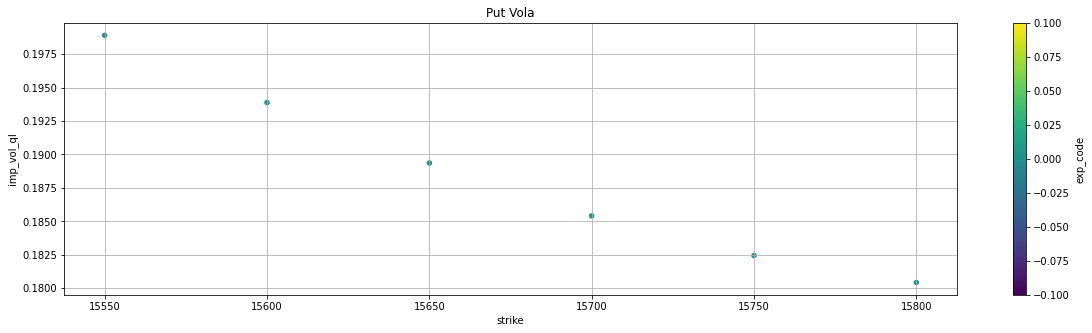

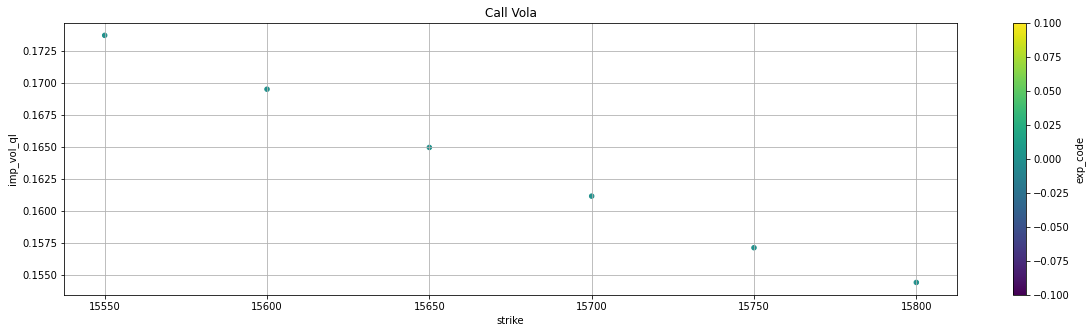

Peer closed connection.


In [24]:
import matplotlib.pyplot as plt

imp_vol_df.expiration = pd.Categorical(imp_vol_df.expiration)
imp_vol_df['exp_code'] = imp_vol_df.expiration.cat.codes

fig, ax = plt.subplots()
imp_vol_df[imp_vol_df.right == 'P'].plot.scatter(x='strike', y='imp_vol_ql', c='exp_code', cmap="viridis", figsize=(20,5), ax=ax, title='Put Vola').grid()

fig, ax = plt.subplots()
imp_vol_df[imp_vol_df.right == 'C'].plot.scatter(x='strike', y='imp_vol_ql', c='exp_code', cmap="viridis", figsize=(20,5), ax=ax, title='Call Vola').grid()

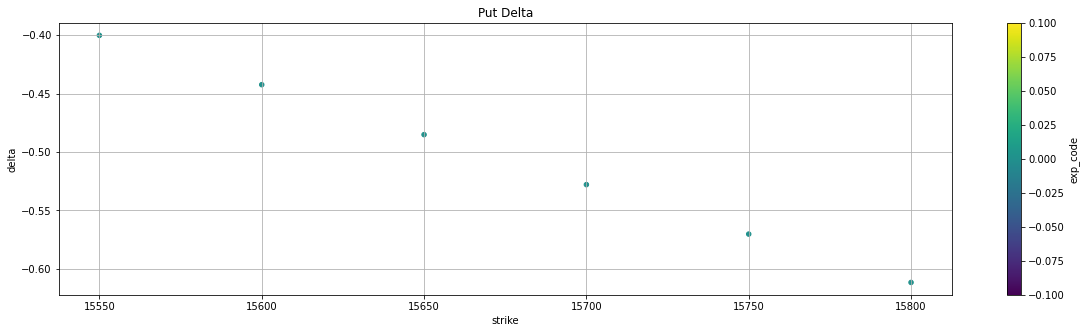

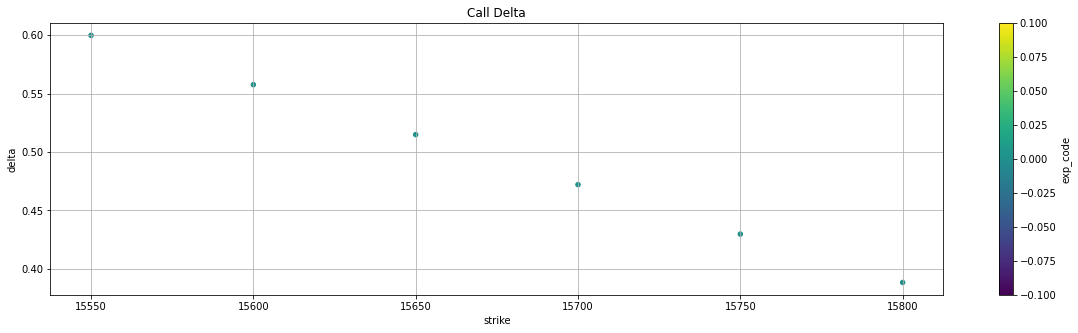

In [20]:
import matplotlib.pyplot as plt

imp_vol_df.expiration = pd.Categorical(imp_vol_df.expiration)
imp_vol_df['exp_code'] = imp_vol_df.expiration.cat.codes

fig, ax = plt.subplots()
imp_vol_df[imp_vol_df.right == 'P'].plot.scatter(x='strike', y='delta', c='exp_code', cmap="viridis", figsize=(20,5), ax=ax, title='Put Delta').grid()

fig, ax = plt.subplots()
imp_vol_df[imp_vol_df.right == 'C'].plot.scatter(x='strike', y='delta', c='exp_code', cmap="viridis", figsize=(20,5), ax=ax, title='Call Delta').grid()

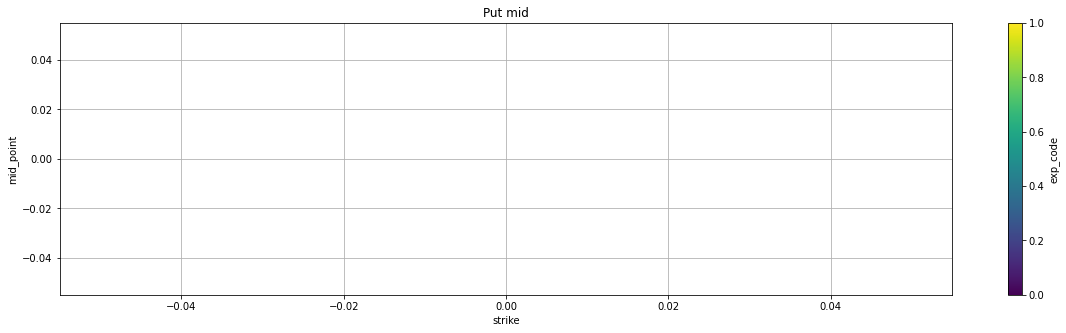

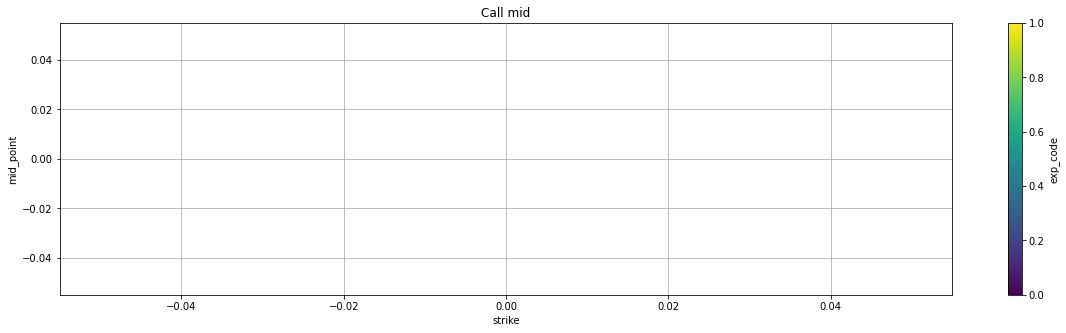

In [14]:
import matplotlib.pyplot as plt

imp_vol_df.expiration = pd.Categorical(imp_vol_df.expiration)
imp_vol_df['exp_code'] = imp_vol_df.expiration.cat.codes

fig, ax = plt.subplots()
imp_vol_df[imp_vol_df.right == 'P'].plot.scatter(x='strike', y='mid_point', c='exp_code', cmap="viridis", figsize=(20,5), ax=ax, title='Put mid').grid()

fig, ax = plt.subplots()
imp_vol_df[imp_vol_df.right == 'C'].plot.scatter(x='strike', y='mid_point', c='exp_code', cmap="viridis", figsize=(20,5), ax=ax, title='Call mid').grid()

In [15]:
#ib.disconnect()